In [2]:
"""
Tensor Meshes
=============

Here we demonstrate various ways that models can be defined and mapped to
tensor meshes. Some things we consider are:

    - Surface topography
    - Adding structures of various shape to the model
    - Parameterized models
    - Models with 2 or more physical properties


"""

'\nTensor Meshes\n=============\n\nHere we demonstrate various ways that models can be defined and mapped to\ntensor meshes. Some things we consider are:\n\n    - Surface topography\n    - Adding structures of various shape to the model\n    - Parameterized models\n    - Models with 2 or more physical properties\n\n\n'

In [3]:
#########################################################################
# Import modules
# --------------
#

from discretize import TensorMesh
from discretize.utils import active_from_xyz
from SimPEG.utils import mkvc, model_builder
from SimPEG import maps
import numpy as np
import matplotlib.pyplot as plt

# sphinx_gallery_thumbnail_number = 3

In [4]:
#############################################
# Defining the mesh
# -----------------
#
# Here, we create the tensor mesh that will be used for all examples.
#


def make_example_mesh():
    dh = 5.0
    hx = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
    hy = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
    hz = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
    mesh = TensorMesh([hx, hy, hz], "CCC")

    return mesh

In [12]:
np.shape(mesh)

(27000,)

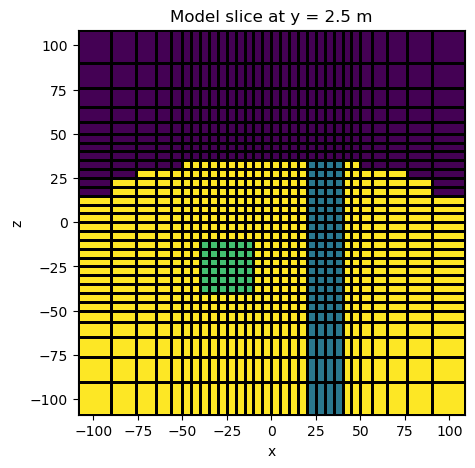

In [5]:
#############################################
# Halfspace model with topography at z = 0
# ----------------------------------------
#
# In this example we generate a half-space model. Since air cells remain
# constant during geophysical inversion, the number of model values we define
# should be equal to the number of cells lying below the surface. Here, we
# define the model (*model* ) as well as the mapping (*model_map* ) that goes from
# the model-space to the entire mesh.
#

mesh = make_example_mesh()

background_value = 100.0
dyke_value = 40.0
block_value = 70.0

# halfspace_value = 100.0

# Define surface topography as an (N, 3) np.array. You could also load a file
# containing the xyz points
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 75**2) + 40.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Find cells below topography and define mapping
air_value = 0.0
#ind_active = mesh.gridCC[:, 2] < 0.0
ind_active = active_from_xyz(mesh, topo, "N")
model_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model
model = background_value * np.ones(ind_active.sum())
ind_dyke = (mesh.gridCC[ind_active, 0] > 20.0) & (mesh.gridCC[ind_active, 0] < 40.0)
model[ind_dyke] = dyke_value
ind_block = (
    (mesh.gridCC[ind_active, 0] > -40.0)
    & (mesh.gridCC[ind_active, 0] < -10.0)
    & (mesh.gridCC[ind_active, 1] > -30.0)
    & (mesh.gridCC[ind_active, 1] < 5.0)
    & (mesh.gridCC[ind_active, 2] > -40.0)
    & (mesh.gridCC[ind_active, 2] < -10.0)
)
model[ind_block] = block_value

#model = halfspace_value * np.ones(ind_active.sum())

# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.shape_cells[1] / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title("Model slice at y = {} m".format(mesh.cell_centers_y[ind_slice]))
plt.show()

In [6]:
np.shape(model)

(18072,)

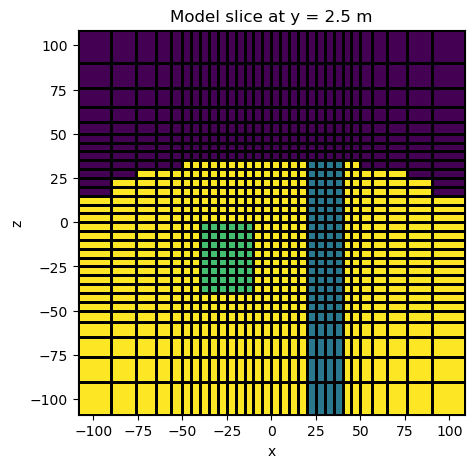

In [7]:
#############################################
# Topography, a block and a vertical dyke
# ---------------------------------------
#
# In this example we create a model containing a block and a vertical dyke
# that strikes along the y direction. The utility *active_from_xyz* is used
# to find the cells which lie below a set of xyz points defining a surface.
#

mesh = make_example_mesh()

background_value = 100.0
dyke_value = 40.0
block_value = 70.0

# Define surface topography as an (N, 3) np.array. You could also load a file
# containing the xyz points
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 75**2) + 40.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Find cells below topography and define mapping
air_value = 0.0
ind_active = active_from_xyz(mesh, topo, "N")
model_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model on subsurface cells
model = background_value * np.ones(ind_active.sum())
ind_dyke = (mesh.gridCC[ind_active, 0] > 20.0) & (mesh.gridCC[ind_active, 0] < 40.0)
model[ind_dyke] = dyke_value
ind_block = (
    (mesh.gridCC[ind_active, 0] > -40.0)
    & (mesh.gridCC[ind_active, 0] < -10.0)
    & (mesh.gridCC[ind_active, 1] > -30.0)
    & (mesh.gridCC[ind_active, 1] < 30.0)
    & (mesh.gridCC[ind_active, 2] > -40.0)
    & (mesh.gridCC[ind_active, 2] < 0.0)
)
model[ind_block] = block_value

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.shape_cells[1] / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title("Model slice at y = {} m".format(mesh.cell_centers_y[ind_slice]))
plt.show()


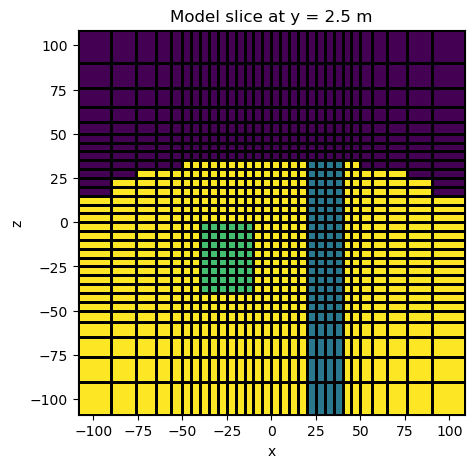

In [8]:
#############################################
# Combo Maps
# ----------
#
# Here we demonstrate how combo maps can be used to create a single mapping
# from the model to the mesh. In this case, our model consists of
# log-conductivity values but we want to plot the resistivity. To accomplish
# this we must take the exponent of our model values, then take the reciprocal,
# then map from below surface cell to the mesh.
#

mesh = make_example_mesh()

background_value = np.log(1.0 / 100.0)
dyke_value = np.log(1.0 / 40.0)
block_value = np.log(1.0 / 70.0)

# Define surface topography
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 75**2) + 40.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Find cells below topography
air_value = 0.0
ind_active = active_from_xyz(mesh, topo, "N")
active_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model on subsurface cells
model = background_value * np.ones(ind_active.sum())
ind_dyke = (mesh.gridCC[ind_active, 0] > 20.0) & (mesh.gridCC[ind_active, 0] < 40.0)
model[ind_dyke] = dyke_value
ind_block = (
    (mesh.gridCC[ind_active, 0] > -40.0)
    & (mesh.gridCC[ind_active, 0] < -10.0)
    & (mesh.gridCC[ind_active, 1] > -30.0)
    & (mesh.gridCC[ind_active, 1] < 30.0)
    & (mesh.gridCC[ind_active, 2] > -40.0)
    & (mesh.gridCC[ind_active, 2] < 0.0)
)
model[ind_block] = block_value

# Define a single mapping from model to mesh
exponential_map = maps.ExpMap()
reciprocal_map = maps.ReciprocalMap()
model_map = active_map * reciprocal_map * exponential_map

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.shape_cells[1] / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title("Model slice at y = {} m".format(mesh.cell_centers_y[ind_slice]))
plt.show()

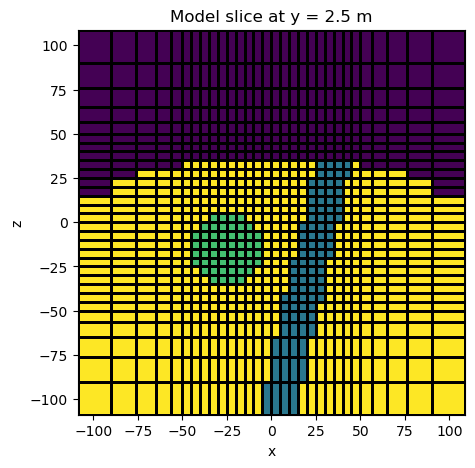

In [13]:
#############################################
# Models with arbitrary shapes
# ----------------------------
#
# Here we show how model building utilities are used to make more complicated
# structural models. The process of adding a new unit is twofold: 1) we must
# find the indicies for mesh cells that lie within the new unit, 2) we
# replace the prexisting physical property value for those cells.
#

mesh = make_example_mesh()

background_value = 100.0
dyke_value = 40.0
sphere_value = 70.0

# Define surface topography
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 75**2) + 40.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Set active cells and define unit values
air_value = 0.0
ind_active = active_from_xyz(mesh, topo, "N")
model_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define model for cells under the surface topography
model = background_value * np.ones(ind_active.sum())

# Add a sphere
ind_sphere = model_builder.get_indices_sphere(
    np.r_[-25.0, 0.0, -15.0], 20.0, mesh.gridCC
)
ind_sphere = ind_sphere[ind_active]  # So it's same size and order as model
model[ind_sphere] = sphere_value

# Add dyke defined by a set of points
xp = np.kron(np.ones((2)), [-10.0, 10.0, 45.0, 25.0])
yp = np.kron([-1000.0, 1000.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-120.0, -120.0, 35.0, 35.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active]  # So same size and order as model
model[ind_polygon] = dyke_value

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.shape_cells[1] / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title("Model slice at y = {} m".format(mesh.cell_centers_y[ind_slice]))
plt.show()

In [ ]:
np.shape(model)

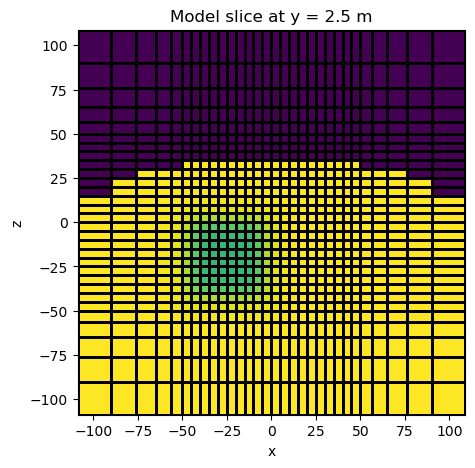

In [10]:
#############################################
# Parameterized block model
# -------------------------
#
# Instead of defining a model value for each sub-surface cell, we can define
# the model in terms of a small number of parameters. Here we parameterize the
# model as a block in a half-space. We then create a mapping which projects
# this model onto the mesh.
#

mesh = make_example_mesh()

background_value = 100.0  # background value
block_value = 40.0  # block value
xc, yc, zc = -25.0, 0.0, -20.0  # center of block
dx, dy, dz = 30.0, 40.0, 30.0  # dimensions in x,y,z

# Define surface topography
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 75**2) + 40.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Set active cells and define unit values
air_value = 0.0
ind_active = active_from_xyz(mesh, topo, "N")
active_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model on subsurface cells
model = np.r_[background_value, block_value, xc, dx, yc, dy, zc, dz]
parametric_map = maps.ParametricBlock(mesh, indActive=ind_active, epsilon=1e-10, p=5.0)

# Define a single mapping from model to mesh
model_map = active_map * parametric_map

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.shape_cells[1] / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title("Model slice at y = {} m".format(mesh.cell_centers_y[ind_slice]))
plt.show()

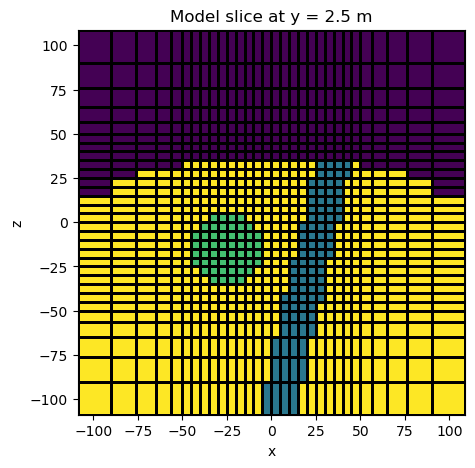

In [11]:
#############################################
# Using Wire Maps
# ---------------
'''

Wire maps are needed when the model is comprised of two or more parameter
types (e.g. conductivity and magnetic permeability). Because the model
vector contains all values for all parameter types, we need to use "wires"
to extract the values for a particular parameter type.

Here we will define a model consisting of log-conductivity values and
magnetic permeability values. We wish to plot the conductivity and
permeability on the mesh. Wires are used to keep track of the mapping
between the model vector and a particular physical property type.

'''


mesh = make_example_mesh()

background_sigma = np.log(100.0)
sphere_sigma = np.log(70.0)
dyke_sigma = np.log(40.0)
background_myu = 1.0
sphere_mu = 1.25

# Define surface topography
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 75**2) + 40.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Set active cells
air_value = 0.0
ind_active = active_from_xyz(mesh, topo, "N")
active_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define model for cells under the surface topography
N = int(ind_active.sum())
model = np.kron(np.ones((N, 1)), np.c_[background_sigma, background_myu])

# Add a conductive and permeable sphere
ind_sphere = model_builder.get_indices_sphere(
    np.r_[-25.0, 0.0, -15.0], 20.0, mesh.gridCC
)
ind_sphere = ind_sphere[ind_active]  # So same size and order as model
model[ind_sphere, :] = np.c_[sphere_sigma, sphere_mu]

# Add a conductive and non-permeable dyke
xp = np.kron(np.ones((2)), [-10.0, 10.0, 45.0, 25.0])
yp = np.kron([-1000.0, 1000.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-120.0, -120.0, 35.0, 35.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active]  # So same size and order as model
model[ind_polygon, 0] = dyke_sigma

# Create model vector and wires
model = mkvc(model)
wire_map = maps.Wires(("log_sigma", N), ("mu", N))

# Use combo maps to map from model to mesh
sigma_map = active_map * maps.ExpMap() * wire_map.log_sigma
mu_map = active_map * wire_map.mu

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.shape_cells[1] / 2)
mesh.plot_slice(sigma_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title("Model slice at y = {} m".format(mesh.cell_centers_y[ind_slice]))
plt.show()